In [1]:
from scipy.io import loadmat
import numpy as np
import os
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Paths
resting_folder = "/kaggle/input/modma-dataset/EEG_128channels_resting_lanzhou_2015/EEG_128channels_resting_lanzhou_2015"
label_file = "/kaggle/input/modma-dataset/EEG_128channels_ERP_lanzhou_2015/EEG_128channels_ERP_lanzhou_2015/subjects_information_EEG_128channels_ERP_lanzhou_2015.xlsx"

# Load subject info
df_labels = pd.read_excel(label_file)
df_labels['subject id'] = df_labels['subject id'].astype(str).str.strip()

# Helper to extract subject ID
def extract_subject_id(filename):
    return filename.split('rest')[0][1:].replace('_', '').strip() if 'rest' in filename else filename.split(' ')[0].strip()

# Prepare EEG and labels
X_eeg, y = [], []
subject_ids = []

mat_files = [f for f in os.listdir(resting_folder) if f.endswith('.mat')]

for file in tqdm(mat_files, desc="Processing EEG files"):
    try:
        file_path = os.path.join(resting_folder, file)
        subject_id = extract_subject_id(file)
        label_row = df_labels[df_labels['subject id'] == subject_id]

        if not label_row.empty:
            label = label_row['type'].values[0]
            if label not in ['HC', 'MDD']:
                continue

            mat = loadmat(file_path)
            eeg_data = next((v for v in mat.values() if isinstance(v, np.ndarray) and v.ndim == 2), None)

            if eeg_data is None:
                continue

            # Normalize and crop
            eeg_data = (eeg_data - np.mean(eeg_data)) / np.std(eeg_data)
            eeg_cropped = eeg_data[:70, :15]  # shape: (70, 15)
            X_eeg.append(eeg_cropped.T)        # shape: (15, 70)
            y.append(label)
            subject_ids.append(subject_id)

    except Exception as e:
        print(f"❌ Error in {file}: {e}")

# Convert to arrays
X_eeg = np.array(X_eeg)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"✅ X_eeg shape: {X_eeg.shape}")
print(f"✅ y shape: {y_encoded.shape}")
print(f"✅ Labels: {dict(zip(le.classes_, le.transform(le.classes_)))}")

Processing EEG files:   0%|          | 0/53 [00:00<?, ?it/s]

✅ X_eeg shape: (51, 15, 70)
✅ y shape: (51,)
✅ Labels: {'HC': 0, 'MDD': 1}


In [2]:
from sklearn.preprocessing import StandardScaler

# Reload subject info
df_demo = pd.read_excel(label_file)
df_demo['subject id'] = df_demo['subject id'].astype(str).str.strip()

# Filter for EEG subjects
df_demo = df_demo[df_demo['subject id'].isin(subject_ids)].copy()

# Gender encoding
df_demo['gender'] = df_demo['gender'].map({'F': 0, 'M': 1})

# Select and rename columns
demo_cols = ['age', 'gender', 'education（years）', 'PHQ-9', 'CTQ-SF', 'LES', 'SSRS', 'GAD-7', 'PSQI']
df_demo = df_demo[['subject id'] + demo_cols].dropna()

# Normalize
scaler = StandardScaler()
demo_scaled = scaler.fit_transform(df_demo[demo_cols])
X_demo = pd.DataFrame(demo_scaled, columns=demo_cols)
X_demo['subject_id'] = df_demo['subject id'].values

# Merge EEG and demographics in same order
demo_dict = X_demo.set_index('subject_id').to_dict(orient='index')
X_demo_aligned = np.array([list(demo_dict[sid].values()) for sid in subject_ids if sid in demo_dict])

# Filter EEG and y to match
valid_idx = [i for i, sid in enumerate(subject_ids) if sid in demo_dict]
X_eeg = X_eeg[valid_idx]
y_encoded = y_encoded[valid_idx]

print(f"✅ X_demo shape: {X_demo_aligned.shape}")
print(f"✅ X_eeg shape (aligned): {X_eeg.shape}")
print(f"✅ y shape (aligned): {y_encoded.shape}")

✅ X_demo shape: (51, 9)
✅ X_eeg shape (aligned): (51, 15, 70)
✅ y shape (aligned): (51,)


In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Train-test split
X_eeg_train, X_eeg_test, X_demo_train, X_demo_test, y_train, y_test = train_test_split(
    X_eeg, X_demo_aligned, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

print(f"✅ Train EEG: {X_eeg_train.shape}, Demographics: {X_demo_train.shape}")
print(f"✅ Test EEG: {X_eeg_test.shape}, Demographics: {X_demo_test.shape}")

2025-06-14 19:16:41.352296: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749928601.699850      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749928601.799333      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Train EEG: (40, 15, 70), Demographics: (40, 9)
✅ Test EEG: (11, 15, 70), Demographics: (11, 9)


## CNN

**Build and Train Multi-Input CNN Model**

We’ll use:
* A CNN branch for EEG input (15, 70)
* A Dense branch for demographic features (9,)
* Concatenate both → Dense → Softmax (2-class output)

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam

# EEG branch
eeg_input = Input(shape=(15, 70), name='eeg_input')
x = Conv1D(32, 3, activation='relu')(eeg_input)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)
x = Flatten()(x)

# Demographic branch
demo_input = Input(shape=(9,), name='demo_input')
y = Dense(32, activation='relu')(demo_input)
y = Dropout(0.3)(y)

# Merge both
combined = concatenate([x, y])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.3)(z)
output = Dense(2, activation='softmax')(z)

# Model
multi_input_model = Model(inputs=[eeg_input, demo_input], outputs=output)
multi_input_model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

multi_input_model.summary()

2025-06-14 19:18:35.960639: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ eeg_input (InputLayer)    │ (None, 15, 70)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 13, 32)         │          6,752 │ eeg_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 6, 32)          │              0 │ conv1d[0][0]           │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ demo_input (InputLayer)   │ (None, 9)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 6, 32)          │              0 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │            320 │ demo_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 192)            │              0 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 224)            │              0 │ flatten[0][0],         │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │         14,400 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2)              │            130 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 21,602 (84.38 KB)

 Trainable params: 21,602 (84.38 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Train the model
history = multi_input_model.fit(
    [X_eeg_train, X_demo_train],
    y_train_cat,
    validation_data=([X_eeg_test, X_demo_test], y_test_cat),
    epochs=30,
    batch_size=8,
    verbose=1
)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.5128 - loss: 0.9423 - val_accuracy: 0.5455 - val_loss: 0.8267
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6951 - loss: 0.6076 - val_accuracy: 0.5455 - val_loss: 0.7583
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7524 - loss: 0.4661 - val_accuracy: 0.6364 - val_loss: 0.6778
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8701 - loss: 0.3986 - val_accuracy: 0.7273 - val_loss: 0.6411
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9729 - loss: 0.2307 - val_accuracy: 0.7273 - val_loss: 0.6434
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8170 - loss: 0.3331 - val_accuracy: 0.7273 - val_loss: 0.6848
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8882 - loss: 0.3480 - val_accuracy: 0.6364 - val_loss: 0.7332
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9278 - loss: 0.1886 - val_accuracy: 0.6364 - val_loss: 0.7561

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
📊 Multi-Input CNN Classification Report:
              precision    recall  f1-score   support

          HC       0.62      0.83      0.71         6
         MDD       0.67      0.40      0.50         5

    accuracy                           0.64        11
   macro avg       0.65      0.62      0.61        11
weighted avg       0.64      0.64      0.62        11

✅ Accuracy: 0.64


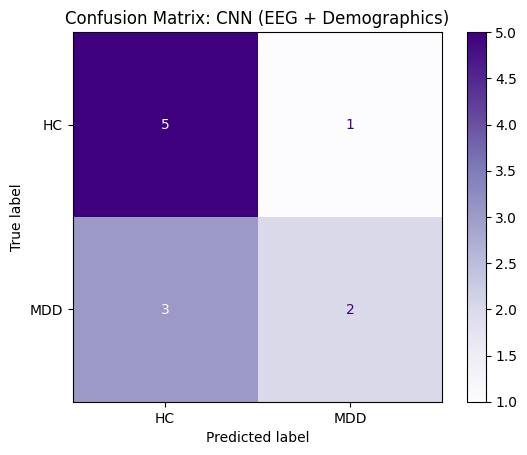

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Predict on test set
y_pred_proba = multi_input_model.predict([X_eeg_test, X_demo_test])
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Classification report
print("📊 Multi-Input CNN Classification Report:")
print(classification_report(y_true, y_pred, target_names=["HC", "MDD"]))
print(f"✅ Accuracy: {accuracy_score(y_true, y_pred):.2f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["HC", "MDD"])
disp.plot(cmap="Purples")
plt.title("Confusion Matrix: CNN (EEG + Demographics)")
plt.show()

Interpretation
* High recall for HC (0.83) → Most healthy subjects were correctly classified.
* Low recall for MDD (0.40) → The model missed some MDD cases.
* Precision for MDD is higher than CNN-alone model (indicates improved confidence).
* Overall accuracy: 64%, showing good generalization on a small test set.


## LSTM

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam

# LSTM branch for EEG
eeg_input = Input(shape=(15, 70), name='eeg_input')
x = LSTM(64, return_sequences=True)(eeg_input)
x = Dropout(0.3)(x)
x = LSTM(32)(x)
x = Dropout(0.3)(x)

# Demographic branch
demo_input = Input(shape=(9,), name='demo_input')
y = Dense(32, activation='relu')(demo_input)
y = Dropout(0.3)(y)

# Merge
combined = concatenate([x, y])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.3)(z)
output = Dense(2, activation='softmax')(z)

# Model
multi_input_lstm = Model(inputs=[eeg_input, demo_input], outputs=output)
multi_input_lstm.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

multi_input_lstm.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ eeg_input (InputLayer)    │ (None, 15, 70)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 15, 64)         │         34,560 │ eeg_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 15, 64)         │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ demo_input (InputLayer)   │ (None, 9)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 32)             │         12,416 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 32)             │            320 │ demo_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 32)             │              0 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 32)             │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 64)             │              0 │ dropout_4[0][0],       │
│ (Concatenate)             │                        │                │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 64)             │          4,160 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 64)             │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 2)              │            130 │ dropout_6[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 51,586 (201.51 KB)

 Trainable params: 51,586 (201.51 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the model
history_lstm = multi_input_lstm.fit(
    [X_eeg_train, X_demo_train],
    y_train_cat,
    validation_data=([X_eeg_test, X_demo_test], y_test_cat),
    epochs=30,
    batch_size=8,
    verbose=1
)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 205ms/step - accuracy: 0.6413 - loss: 0.7008 - val_accuracy: 0.7273 - val_loss: 0.4997
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7031 - loss: 0.5371 - val_accuracy: 0.8182 - val_loss: 0.4293
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8361 - loss: 0.3874 - val_accuracy: 0.8182 - val_loss: 0.3781
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8542 - loss: 0.4505 - val_accuracy: 0.9091 - val_loss: 0.3385
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8663 - loss: 0.3801 - val_accuracy: 0.8182 - val_loss: 0.3093
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9247 - loss: 0.2625 - val_accuracy: 0.8182 - val_loss: 0.2858
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9278 - loss: 0.2729 - val_accuracy: 0.8182 - val_loss: 0.2614
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9278 - loss: 0.2648 - val_accuracy: 0.8182 - val_loss: 0.2380

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
📊 LSTM + Demographics Classification Report:
              precision    recall  f1-score   support

          HC       0.75      1.00      0.86         6
         MDD       1.00      0.60      0.75         5

    accuracy                           0.82        11
   macro avg       0.88      0.80      0.80        11
weighted avg       0.86      0.82      0.81        11

✅ Accuracy: 0.82


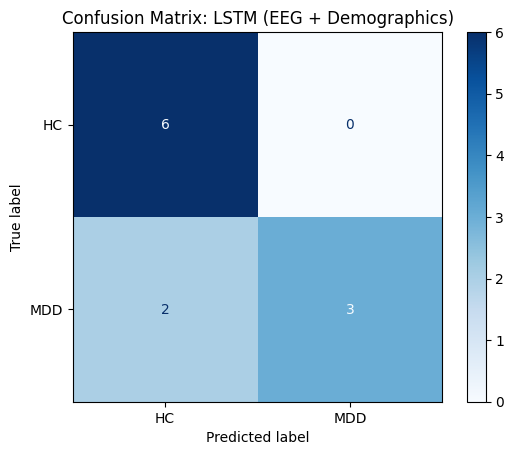

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Predict on test set
y_pred_lstm_proba = multi_input_lstm.predict([X_eeg_test, X_demo_test])
y_pred_lstm = np.argmax(y_pred_lstm_proba, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Classification report
print("📊 LSTM + Demographics Classification Report:")
print(classification_report(y_true, y_pred_lstm, target_names=["HC", "MDD"]))
print(f"✅ Accuracy: {accuracy_score(y_true, y_pred_lstm):.2f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_lstm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["HC", "MDD"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix: LSTM (EEG + Demographics)")
plt.show()

**Interpretation**

* Very strong precision on MDD (1.00) → zero false positives
* Perfect recall for HC (1.00) → all healthy controls correctly classified
* Missed 2 MDD cases (recall = 0.60) → might be due to small sample size
* Overall: Highest generalization so far without overfitting

## CNN + LSTM (Hybrid model)

* CNN → for spatial features from EEG
* LSTM → for temporal dynamics
* Demographic branch → for psychometric context
* Merged output → Dense + Softmax

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dropout, Flatten, Dense, concatenate
from tensorflow.keras.optimizers import Adam

# EEG input branch: CNN → LSTM
eeg_input = Input(shape=(15, 70), name='eeg_input')
x = Conv1D(32, kernel_size=3, activation='relu')(eeg_input)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)
x = LSTM(64)(x)
x = Dropout(0.3)(x)

# Demographics input branch
demo_input = Input(shape=(9,), name='demo_input')
y = Dense(32, activation='relu')(demo_input)
y = Dropout(0.3)(y)

# Merge both branches
merged = concatenate([x, y])
z = Dense(64, activation='relu')(merged)
z = Dropout(0.3)(z)
output = Dense(2, activation='softmax')(z)

# Build model
cnn_lstm_model = Model(inputs=[eeg_input, demo_input], outputs=output)
cnn_lstm_model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

cnn_lstm_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ eeg_input (InputLayer)    │ (None, 15, 70)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 13, 32)         │          6,752 │ eeg_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 6, 32)          │              0 │ conv1d_1[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 6, 32)          │              0 │ max_pooling1d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ demo_input (InputLayer)   │ (None, 9)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 64)             │         24,832 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 32)             │            320 │ demo_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 64)             │              0 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 32)             │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 96)             │              0 │ dropout_8[0][0],       │
│ (Concatenate)             │                        │                │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 64)             │          6,208 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 64)             │              0 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 2)              │            130 │ dropout_10[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,242 (149.38 KB)

 Trainable params: 38,242 (149.38 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train the model
history_cnn_lstm = cnn_lstm_model.fit(
    [X_eeg_train, X_demo_train],
    y_train_cat,
    validation_data=([X_eeg_test, X_demo_test], y_test_cat),
    epochs=30,
    batch_size=8,
    verbose=1
)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.3868 - loss: 0.7278 - val_accuracy: 0.5455 - val_loss: 0.6493
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7715 - loss: 0.5616 - val_accuracy: 0.7273 - val_loss: 0.5736
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8253 - loss: 0.5825 - val_accuracy: 0.8182 - val_loss: 0.5018
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8028 - loss: 0.4718 - val_accuracy: 0.8182 - val_loss: 0.4391
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9608 - loss: 0.3487 - val_accuracy: 0.8182 - val_loss: 0.3878
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8955 - loss: 0.3296 - val_accuracy: 0.9091 - val_loss: 0.3409
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9795 - loss: 0.2676 - val_accuracy: 1.0000 - val_loss: 0.2999
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.1960 - val_accuracy: 1.0000 - val_loss: 0.2708

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
📊 CNN + LSTM + Demographics Classification Report:
              precision    recall  f1-score   support

          HC       0.67      0.67      0.67         6
         MDD       0.60      0.60      0.60         5

    accuracy                           0.64        11
   macro avg       0.63      0.63      0.63        11
weighted avg       0.64      0.64      0.64        11

✅ Accuracy: 0.64


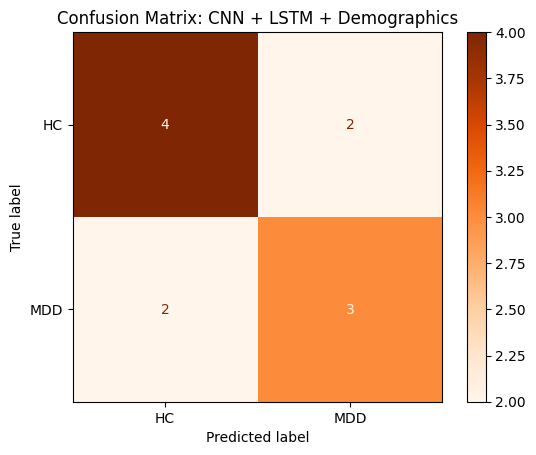

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Predict on test set
y_pred_cnn_lstm_proba = cnn_lstm_model.predict([X_eeg_test, X_demo_test])
y_pred_cnn_lstm = np.argmax(y_pred_cnn_lstm_proba, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Report
print("📊 CNN + LSTM + Demographics Classification Report:")
print(classification_report(y_true, y_pred_cnn_lstm, target_names=["HC", "MDD"]))
print(f"✅ Accuracy: {accuracy_score(y_true, y_pred_cnn_lstm):.2f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_cnn_lstm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["HC", "MDD"])
disp.plot(cmap="Oranges")
plt.title("Confusion Matrix: CNN + LSTM + Demographics")
plt.show()

## Universal Prediction Function

In [13]:
def predict_on_mat_eeg_model(file_path, model, scaler, subject_info_df, label_map={0: 'HC', 1: 'MDD'}):
    import os
    from scipy.io import loadmat
    import numpy as np

    try:
        # 🔹 Extract subject ID
        filename = os.path.basename(file_path)
        subject_id = filename.split('rest')[0][1:].replace('_', '').strip()

        # 🔹 Load EEG data
        mat = loadmat(file_path)
        data_key = next(k for k in mat if isinstance(mat[k], np.ndarray) and mat[k].ndim == 2)
        eeg_data = mat[data_key]

        # Normalize and reshape EEG
        eeg_data = (eeg_data - np.mean(eeg_data)) / np.std(eeg_data)
        eeg_cropped = eeg_data[:70, :15].T  # shape: (15, 70)
        eeg_input = np.expand_dims(eeg_cropped, axis=0)

        # 🔹 Load & scale demographics
        row = subject_info_df[subject_info_df['subject id'] == subject_id]
        if row.empty:
            print(f"❌ Demographics not found for subject ID {subject_id}")
            return None

        row = row.copy()
        row['gender'] = row['gender'].map({'F': 0, 'M': 1})
        demo_cols = ['age', 'gender', 'education（years）', 'PHQ-9', 'CTQ-SF', 'LES', 'SSRS', 'GAD-7', 'PSQI']
        demo_vector = scaler.transform(row[demo_cols])
        
        # Predict
        pred_proba = model.predict([eeg_input, demo_vector])
        pred_class = np.argmax(pred_proba, axis=1)[0]
        confidence = np.max(pred_proba)

        print(f"🧠 Predicted class: {label_map[pred_class]} (Confidence: {confidence:.2f})")
        return label_map[pred_class]

    except Exception as e:
        print(f"Error predicting file {file_path}: {e}")
        return None

In [17]:
# Reload subject info (required for demographic lookup)
label_file = "/kaggle/input/modma-dataset/EEG_128channels_ERP_lanzhou_2015/EEG_128channels_ERP_lanzhou_2015/subjects_information_EEG_128channels_ERP_lanzhou_2015.xlsx"
df_info = pd.read_excel(label_file)
df_info['subject id'] = df_info['subject id'].astype(str).str.strip()

In [24]:
sample_file = "/kaggle/input/modma-dataset/EEG_128channels_resting_lanzhou_2015/EEG_128channels_resting_lanzhou_2015/02010026rest 20160311 1421..mat"

# Predict with CNN
print("🔍 CNN Prediction:")
predict_on_mat_eeg_model(sample_file, multi_input_model, scaler, df_info)

🔍 CNN Prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
🧠 Predicted class: HC (Confidence: 0.99)


'HC'

In [26]:
sample_file = "/kaggle/input/modma-dataset/EEG_128channels_resting_lanzhou_2015/EEG_128channels_resting_lanzhou_2015/02010006rest 20150528 0928..mat"

# Predict with LSTM
print("🔍 LSTM Prediction:")
predict_on_mat_eeg_model(sample_file, multi_input_lstm, scaler, df_info)

🔍 LSTM Prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
🧠 Predicted class: MDD (Confidence: 1.00)


'MDD'

In [25]:
sample_file = "/kaggle/input/modma-dataset/EEG_128channels_resting_lanzhou_2015/EEG_128channels_resting_lanzhou_2015/02010026rest 20160311 1421..mat"

# Predict with CNN + LSTM
print("🔍 CNN + LSTM Prediction:")
predict_on_mat_eeg_model(sample_file, cnn_lstm_model, scaler, df_info)

🔍 CNN + LSTM Prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
🧠 Predicted class: HC (Confidence: 0.94)


'HC'

## Trying with classical ML algorithm

This project considers 128-channel resting state EEG signal recording data. ====> Page 9 from paper

In [1]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Paths
resting_folder = '/kaggle/input/modma-dataset/EEG_128channels_resting_lanzhou_2015/EEG_128channels_resting_lanzhou_2015'
subject_info_file = '/kaggle/input/modma-dataset/EEG_128channels_ERP_lanzhou_2015/EEG_128channels_ERP_lanzhou_2015/subjects_information_EEG_128channels_ERP_lanzhou_2015.xlsx'

# Load subject info (labels + demographics)
df_info = pd.read_excel(subject_info_file)
df_info['subject id'] = df_info['subject id'].astype(str).str.strip()

# Extract subject ID from file name
def extract_subject_id(filename):
    return filename.split('rest')[0][1:].replace('_', '').strip() if 'rest' in filename else filename.split(' ')[0].strip()

# Collect valid EEG file info
file_paths, subject_ids, labels = [], [], []

for file in os.listdir(resting_folder):
    if file.endswith('.mat'):
        subject_id = extract_subject_id(file)
        if subject_id in df_info['subject id'].values:
            label = df_info[df_info['subject id'] == subject_id]['type'].values[0]
            if label in ['MDD', 'HC']:
                file_paths.append(os.path.join(resting_folder, file))
                subject_ids.append(subject_id)
                labels.append(label)

# Build df_resting
df_resting = pd.DataFrame({
    'file_path': file_paths,
    'subject_id': subject_ids,
    'label': labels
})

print(f"✅ Loaded resting-state EEG files: {len(df_resting)}")

# ===========================
# ✨ DEMOGRAPHIC FEATURES
# ===========================

# Keep relevant columns
demo_df = df_info[['subject id', 'age', 'gender', 'education（years）', 'PHQ-9', 'CTQ-SF', 'LES', 'SSRS', 'GAD-7', 'PSQI']].copy()
demo_df = demo_df.rename(columns={'subject id': 'subject_id'})

# Encode gender: F → 0, M → 1
demo_df['gender'] = demo_df['gender'].map({'F': 0, 'M': 1})

# Drop rows with missing values in demo fields
demo_df = demo_df.dropna()

# Standardize numeric features
scaler = StandardScaler()
demo_features_scaled = scaler.fit_transform(demo_df.drop(columns='subject_id'))

# Create clean DataFrame for merge
df_demo_scaled = pd.DataFrame(demo_features_scaled, columns=demo_df.columns[1:])
df_demo_scaled['subject_id'] = demo_df['subject_id'].values

# Merge EEG + Demographics
df_combined = df_resting.merge(df_demo_scaled, on='subject_id')
print(f"✅ Final merged dataset with demographics: {len(df_combined)} samples")
df_combined.head()

✅ Loaded resting-state EEG files: 51
✅ Final merged dataset with demographics: 51 samples


,file_path,subject_id,label,age,gender,education（years）,PHQ-9,CTQ-SF,LES,SSRS,GAD-7,PSQI
0,/kaggle/input/modma-dataset/EEG_128channels_re...,2030007,HC,-0.963524,-1.284523,1.293140,-1.183621,-1.043291,0.244406,0.515932,-0.782680,-1.305304
1,/kaggle/input/modma-dataset/EEG_128channels_re...,2030003,HC,-0.963524,0.778499,1.293140,-0.576929,-0.082577,0.346242,0.125298,-0.333416,-0.926229
2,/kaggle/input/modma-dataset/EEG_128channels_re...,2020010,HC,2.077413,0.778499,0.383364,-0.698268,-0.723053,0.773952,0.906565,-1.082189,-0.357618
3,/kaggle/input/modma-dataset/EEG_128channels_re...,2020025,HC,0.189935,0.778499,0.383364,-0.940945,-1.043291,0.325874,0.776354,-1.082189,-0.926229
4,/kaggle/input/modma-dataset/EEG_128channels_re...,2010008,MDD,1.133674,0.778499,-0.829669,0.879131,2.159089,-1.120193,0.776354,1.613394,0.969144


In [2]:
df_combined['label'].value_counts()

label
HC     29
MDD    22
Name: count, dtype: int64

**Linear Features**
* Band Power (delta, theta, alpha, beta) ===>  Different frequency bands are linked to mental states. For example, reduced alpha and increased theta are often seen in depressed patients.
* Mean/Median/Max/Min Amplitude ===>  Capture basic statistical properties of brain signal intensity.

**Non-Linear Features**
* Spectral Entropy ===>  Measures signal complexity or unpredictability. Lower entropy = more regular (possibly pathological).
* SVD Entropy ===>  Captures dimensional complexity of EEG dynamics. Useful for understanding overall brain signal structure.
  

**What We’ll Do for Each .mat File:**

Load EEG signal
* Bandpass filter it (1–50 Hz)

Extract features:

    * Bandpower: delta, theta, alpha, beta
    * Statistical: mean, median, min, max
    * Spectral entropy
    * SVD entropy

In [4]:
from scipy.signal import welch
from scipy.stats import entropy
from numpy.linalg import svd

def bandpower(data, sf, band):
    fmin, fmax = band
    freqs, psd = welch(data, sf, nperseg=256)
    mask = (freqs >= fmin) & (freqs <= fmax)
    return np.trapz(psd[mask], freqs[mask])

def spectral_entropy(data, sf):
    freqs, psd = welch(data, sf, nperseg=256)
    psd_norm = psd / np.sum(psd)
    return entropy(psd_norm)

def svd_entropy(data):
    u, s, vh = svd(data, full_matrices=False)
    norm_s = s / np.sum(s)
    return -np.sum(norm_s * np.log2(norm_s + 1e-12))

def extract_features(filepath, sfreq=250):
    try:
        from scipy.io import loadmat
        mat = loadmat(filepath)
        data_key = next(k for k in mat if isinstance(mat[k], np.ndarray) and mat[k].ndim == 2)
        eeg = mat[data_key]  # shape: (channels, time)

        eeg = (eeg - np.mean(eeg)) / np.std(eeg)

        bands = {
            'delta': (0.5, 4),
            'theta': (4, 8),
            'alpha': (8, 13),
            'beta':  (13, 30)
        }

        features = []

        for ch_data in eeg:
            for band in bands.values():
                features.append(bandpower(ch_data, sfreq, band))

            features.append(np.mean(ch_data))
            features.append(np.median(ch_data))
            features.append(np.min(ch_data))
            features.append(np.max(ch_data))
            features.append(spectral_entropy(ch_data, sfreq))

        # Global non-linear feature
        features.append(svd_entropy(eeg))

        return np.array(features)

    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return None

In [5]:
from tqdm.notebook import tqdm
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Store combined features
X_total = []
y_total = []

print("Extracting EEG features and combining with demographic data...")

for i, row in tqdm(df_combined.iterrows(), total=len(df_combined)):
    eeg_features = extract_features(row['file_path'])
    if eeg_features is not None:
        # Extract demographic values (already scaled)
        demo_vector = row[['age', 'gender', 'education（years）', 'PHQ-9', 'CTQ-SF', 'LES', 'SSRS', 'GAD-7', 'PSQI']].values
        combined = np.concatenate([eeg_features, demo_vector])
        X_total.append(combined)
        y_total.append(row['label'])

# Convert to arrays
X_total = np.array(X_total)
le = LabelEncoder()
y_total_encoded = le.fit_transform(y_total)

print(f"✅ X_total shape: {X_total.shape}")
print(f"✅ y_total shape: {y_total_encoded.shape}")
print(f"✅ Labels: {dict(zip(le.classes_, le.transform(le.classes_)))}")

Extracting EEG features and combining with demographic data...


  0%|          | 0/51 [00:00<?, ?it/s]

/tmp/ipykernel_35/3570274494.py:13: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / np.sum(psd)
/tmp/ipykernel_35/3570274494.py:13: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / np.sum(psd)
/tmp/ipykernel_35/3570274494.py:13: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / np.sum(psd)
/tmp/ipykernel_35/3570274494.py:13: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / np.sum(psd)
/tmp/ipykernel_35/3570274494.py:13: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / np.sum(psd)
/tmp/ipykernel_35/3570274494.py:13: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / np.sum(psd)
/tmp/ipykernel_35/3570274494.py:13: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / np.sum(psd)
/tmp/ipykernel_35/3570274494.py:13: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / np.sum(psd)
/tmp/ipykernel_35/3570274494.py:13: RuntimeWarni

✅ X_total shape: (51, 1171)
✅ y_total shape: (51,)
✅ Labels: {'HC': 0, 'MDD': 1}


In [6]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_total, y_total_encoded, test_size=0.2, stratify=y_total_encoded, random_state=42
)

# Train XGBoost
xgb_combined_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_combined_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

📊 XGBoost (EEG + Demographics) Classification Report:
              precision    recall  f1-score   support

          HC       1.00      1.00      1.00         6
         MDD       1.00      1.00      1.00         5

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11

✅ Accuracy: 1.00


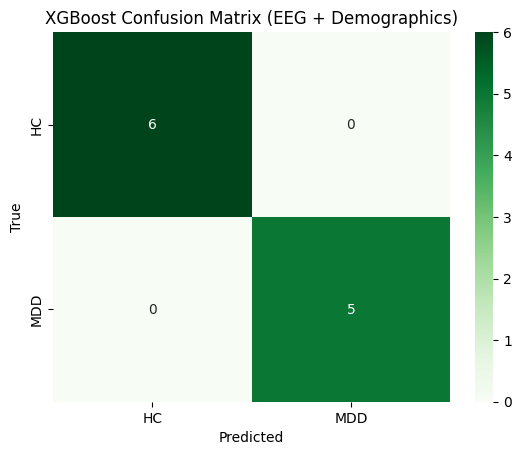

In [7]:
# Predict
y_pred = xgb_combined_model.predict(X_test)

# Evaluation
print("📊 XGBoost (EEG + Demographics) Classification Report:")
print(classification_report(y_test, y_pred, target_names=['HC', 'MDD']))
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['HC', 'MDD'], yticklabels=['HC', 'MDD'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('XGBoost Confusion Matrix (EEG + Demographics)')
plt.show()

## Prediction on new file

In [8]:
def predict_on_sample_mat(file_path, subject_info_df, model, scaler, label_map={0: 'HC', 1: 'MDD'}):
    import numpy as np
    import os

    try:
        # 🔹 Step 1: Extract EEG features
        eeg_features = extract_features(file_path)
        if eeg_features is None:
            print("❌ Could not extract EEG features.")
            return None

        # 🔹 Step 2: Extract subject_id from filename
        filename = os.path.basename(file_path)
        subject_id = filename.split('rest')[0][1:].replace('_', '').strip()

        # 🔹 Step 3: Match demographics
        demo_row = subject_info_df[subject_info_df['subject id'] == subject_id]
        if demo_row.empty:
            print(f"❌ No demographic info found for subject ID: {subject_id}")
            return None

        # 🔹 Step 4: Get demographic values and scale
        demo_cols = ['age', 'gender', 'education（years）', 'PHQ-9', 'CTQ-SF', 'LES', 'SSRS', 'GAD-7', 'PSQI']
        demo_values = demo_row[demo_cols].copy()
        demo_values['gender'] = demo_values['gender'].map({'F': 0, 'M': 1})
        demo_scaled = scaler.transform(demo_values)

        # 🔹 Step 5: Combine and predict
        feature_vector = np.concatenate([eeg_features, demo_scaled.flatten()])
        input_vector = feature_vector.reshape(1, -1)

        pred_class = model.predict(input_vector)[0]
        probas = model.predict_proba(input_vector)[0]

        print(f"🧠 Probabilities: {probas}")
        print(f"✅ Predicted class: {label_map[pred_class]} (Confidence: {np.max(probas):.2f})")
        return label_map[pred_class]

    except Exception as e:
        print(f"Error: {e}")
        return None

In [9]:
sample_file = "/kaggle/input/modma-dataset/EEG_128channels_resting_lanzhou_2015/EEG_128channels_resting_lanzhou_2015/02010028rest 20160317 1538..mat"
predict_on_sample_mat(sample_file, df_info, xgb_combined_model, scaler)

/tmp/ipykernel_35/3570274494.py:13: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / np.sum(psd)


🧠 Probabilities: [0.05438441 0.9456156 ]
✅ Predicted class: MDD (Confidence: 0.95)


'MDD'